In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from itertools import cycle
from tqdm.auto import trange
from tqdm.notebook import tqdm

from matplotlib import cm
import matplotlib.pyplot as plt

from utils import plot_utils, s3w_utils, vmf_utils, utils
from utils.nf import normalizing_flows
from methods import s3w, ssw, sw

from experiments import gf_particles, gd_sphere

from scipy.stats import gaussian_kde
from scipy.spatial.distance import pdist, squareform


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# symmetry
A = vmf_utils.rand_vmf(np.array([1, 0, 0]), kappa=10, N=1000)
B = vmf_utils.rand_vmf(np.array([0, 1, 0]), kappa=10, N=1000)
A, B = torch.tensor(A, dtype=torch.float32, device=device), torch.tensor(B, dtype=torch.float32, device=device)

swd_ab, _ = s3w.s3wd(A, B, p=2, device=device)
swd_ba, _ = s3w.s3wd(B, A, p=2, device=device)

print("SWD(A, B):", swd_ab)
print("SWD(B, A):", swd_ba)

Optimizing h: 100%|█████████████████████████████████████| 2000/2000 [00:08<00:00, 245.93it/s, loss=43.7125]

SWD(A, B): 44.539547587841945
SWD(B, A): 45.258240117735035


In [4]:
C = vmf_utils.rand_vmf(np.array([0, 0, 1]), kappa=10, N=1000)
C = torch.tensor(C, dtype=torch.float32, device=device)

swd_ac, _ = s3w.s3wd(A, C, p=2, device=device)
swd_bc, _ = s3w.s3wd(B, C, p=2, device=device)

print("SWD(A, C):", swd_ac)
print("SWD(A, B) + SWD(B, C):", swd_ab + swd_bc)

Optimizing h: 100%|████████████████████████████████████| 2000/2000 [00:08<00:00, 247.51it/s, loss=198.7722]


SWD(A, C): 184.96524166633858
SWD(A, B) + SWD(B, C): 245.33405102126753


In [5]:
swd_aa, _ = s3w.s3wd(A, A, p=2, device=device)
swd_bb, _ = s3w.s3wd(B, B, p=2, device=device)

print("SWD(A, A):", swd_aa)
print("SWD(B, B):", swd_bb)

Optimizing h: 100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 246.69it/s, loss=0.0001]


SWD(A, A): 1e-06
SWD(B, B): 1e-06


In [7]:
_, h = s3w.s3wd(A, B, p=2, device=device)
A_ = h(s3w_utils.get_stereo_proj_torch(A)).detach().cpu().numpy()
B_ = h(s3w_utils.get_stereo_proj_torch(B)).detach().cpu().numpy()



Optimizing h: 100%|█████████████████████████████████████| 2000/2000 [00:09<00:00, 222.02it/s, loss=43.1398]


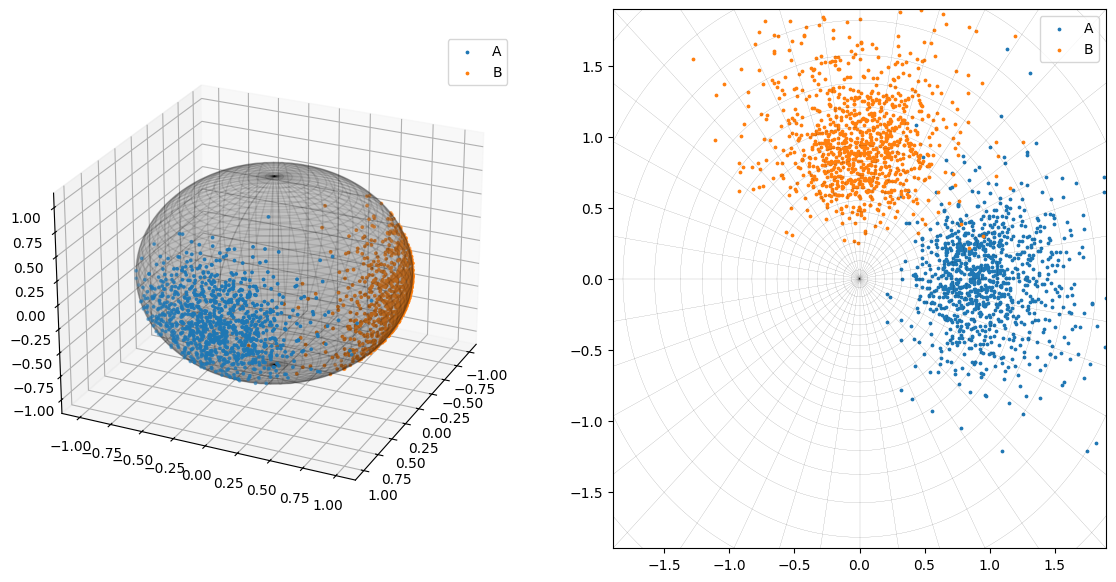

In [8]:
plot_utils.plot_all([A.clone().detach().cpu().numpy(), B.clone().detach().cpu().numpy()], ['A', 'B'])

In [14]:
def geod(x, y): return np.arccos(np.clip(np.sum(x * y, axis=-1), -1, 1))
def eud(x, y): return np.linalg.norm(x - y, axis=-1)

In [15]:
mu = np.array([1, 0, 0])
kappas = [5, 10, 20, 40]
N = 5000

In [16]:
mu = np.array([1, 0, 0])
A = vmf_utils.rand_vmf(mu, kappa=10, N=N)  
A_torch = torch.tensor(A, dtype=torch.float).to(device)

In [28]:
h = None  
for k in kappas:
    B = vmf_utils.rand_vmf(mu, k, N)
    B_torch = torch.tensor(B, dtype=torch.float).to(device)
    _, h = s3w.s3wd(A_torch, B_torch, p=1, n_iters=0, device=device)

In [29]:
A_proj = s3w_utils.get_stereo_proj_torch(torch.tensor(A, dtype=torch.float)).to(device)
B_proj = s3w_utils.get_stereo_proj_torch(torch.tensor(B, dtype=torch.float)).to(device)

A_ = h(A_proj).cpu().detach().numpy()
B_ = h(B_proj).cpu().detach().numpy()

ed = eud(A_, B_) 
gd = geod(A, B)

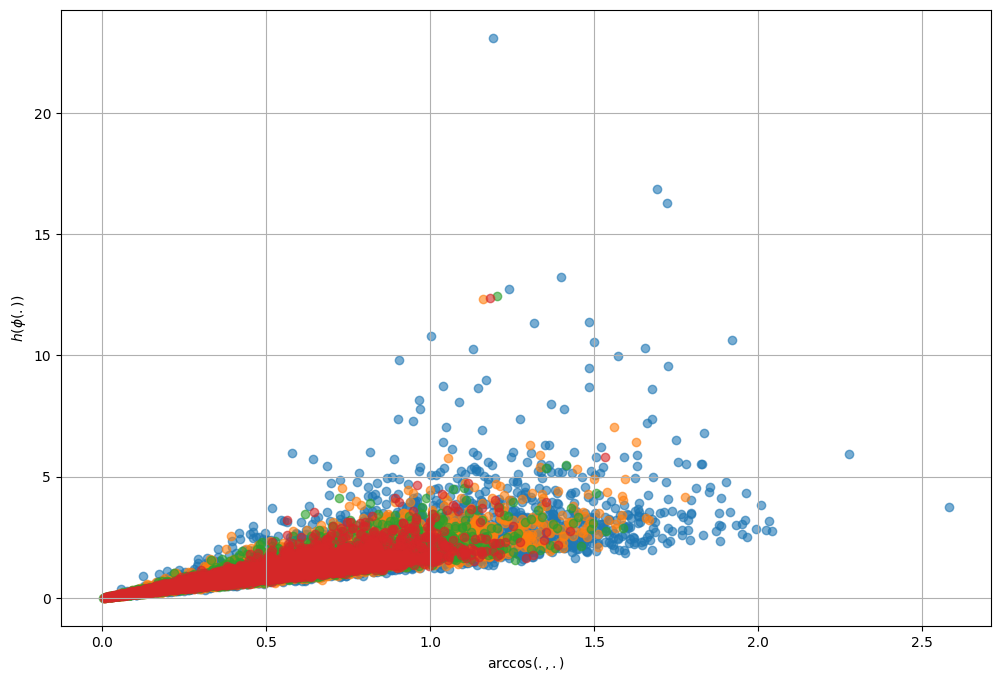

In [37]:
plt.figure(figsize=(12, 8))
for k in kappas:
    B = vmf_utils.rand_vmf(mu, k, N)
    B_torch = torch.tensor(B, dtype=torch.float).to(device)
    A_proj = s3w_utils.get_stereo_proj_torch(A_torch)
    B_proj = s3w_utils.get_stereo_proj_torch(B_torch)

    A_ = h(A_proj).cpu().detach().numpy()
    B_ = h(B_proj).cpu().detach().numpy()

    ed = eud(A_, B_)
    gd = geod(A, B)
    
    plt.scatter(gd, ed, alpha=0.6, label=f'kappa={k}')
plt.xlabel(r'$\arccos(.,.)$') 
plt.ylabel(r'$h(\phi(.))$') 
plt.grid(True)
plt.show()